In [10]:
import h5py
import mne
import numpy as np
import pandas as pd

from mspca import mspca

# Giving Labels


In [2]:
# Severe=3,normal=0,Moderate=2,light=1
label=pd.read_csv('labels.csv')
label['labels'] = 0
for i in range(len(label)):
    valence = label.loc[i, 'valence']
    arousal = label.loc[i, 'Arousal']
    
    # Classify as 'Anxious' or 'Normal' first
    if valence <= 5 and arousal >= 5:
        # Within the 'Anxious' category, apply further classification
        if 0 < valence <= 2 and 7 <= arousal <= 9:
            label.loc[i, 'labels'] = 3
        elif 2 < valence <= 4 and 6 <= arousal < 7:
            label.loc[i, 'labels'] = 2
        elif 4 < valence <= 5 and 5 <= arousal < 6:
            label.loc[i, 'labels'] = 1

labels = pd.DataFrame(pd.concat([label['labels']]*2).sort_index(kind='merge'))
print(labels['labels'].value_counts())



labels
0    156
3     90
1     20
2     10
Name: count, dtype: int64


In [6]:
file_path = './Preprocessed_data(mat)/S01preprocessed.mat'
with h5py.File(file_path, 'r') as file:
    first_key = list(file.keys())[0]
    data = np.array(file[first_key])
    data=data*1e-6

In [37]:
sfreq = 128  # Placeholder for the actual sampling frequency
ch_names = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4',]
data=data.reshape(12,14,1920)
# Create an MNE Info object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
montage = mne.channels.make_standard_montage('standard_1020')

# Initialize an empty list to store the filtered data arrays
filtered_data = []

# Define the band-pass filter parameters
l_freq = 4.0  # Low frequency cutoff for the band-pass filter
h_freq = 45.0  # High frequency cutoff for the band-pass filter

# Apply band-pass filter to each chunk and store the filtered data
for i in range(data.shape[0]):  # Loop through the chunks
    # Create a RawArray object for the current chunk
    raw = mne.io.RawArray(data[i, :, :], info)  # Data should be transposed to match MNE structure

    # Apply the band-pass filter
    raw.filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin')

    # Append the filtered data to our list
    filtered_data.append(raw.get_data())

# Convert the list of filtered data arrays to a numpy array if necessary
filtered_data = np.array(filtered_data)
raw.set_montage(montage)

Creating RawArray with float64 data, n_channels=14, n_times=1920
    Range : 0 ... 1919 =      0.000 ...    14.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 213 samples (1.664 s)

Creating RawArray with float64 data, n_channels=14, n_times=1920
    Range : 0 ... 1919 =      0.000 ...    14.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass 

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,17 points
Good channels,14 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,4.00 Hz
Lowpass,45.00 Hz


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 15.000 (s)


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


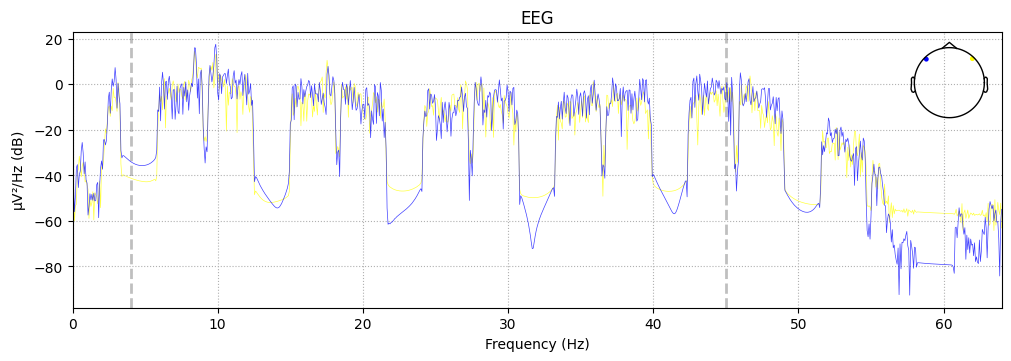

In [38]:
selected_channel=['F7','F8']
raw.pick_channels(selected_channel).plot_psd()

In [39]:
noise_free=[]
mymodel = mspca.MultiscalePCA()
for i in range(len(filtered_data)):
    X=filtered_data[i]
    X_pred=mymodel.fit_transform(X, wavelet_func='db4', threshold=2)
    noise_free.append(X_pred)
noise_free=np.array(noise_free)

In [40]:

sfreq = 128  # Placeholder for the actual sampling frequency
ch_names = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4',]

# Create an MNE Info object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
montage = mne.channels.make_standard_montage('standard_1020')

# Initialize an empty list to store the filtered data arrays
new_filtered_data = []

# Define the band-pass filter parameters
l_freq = 4.0  # Low frequency cutoff for the band-pass filter
h_freq = 45.0  # High frequency cutoff for the band-pass filter

# Apply band-pass filter to each chunk and store the filtered data
for i in range(noise_free.shape[0]):  # Loop through the chunks
    # Create a RawArray object for the current chunk
    new_raw = mne.io.RawArray(noise_free[i, :, :], info)  # Data should be transposed to match MNE structure

    # Apply the band-pass filter
    new_raw=new_raw.filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin')

    # Append the filtered data to our list
    new_filtered_data.append(new_raw.get_data())

# Convert the list of filtered data arrays to a numpy array if necessary
new_filtered_data = np.array(new_filtered_data)
new_raw.set_montage(montage)

Creating RawArray with float64 data, n_channels=14, n_times=1920
    Range : 0 ... 1919 =      0.000 ...    14.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 213 samples (1.664 s)

Creating RawArray with float64 data, n_channels=14, n_times=1920
    Range : 0 ... 1919 =      0.000 ...    14.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass 

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,17 points
Good channels,14 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,4.00 Hz
Lowpass,45.00 Hz


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 15.000 (s)


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


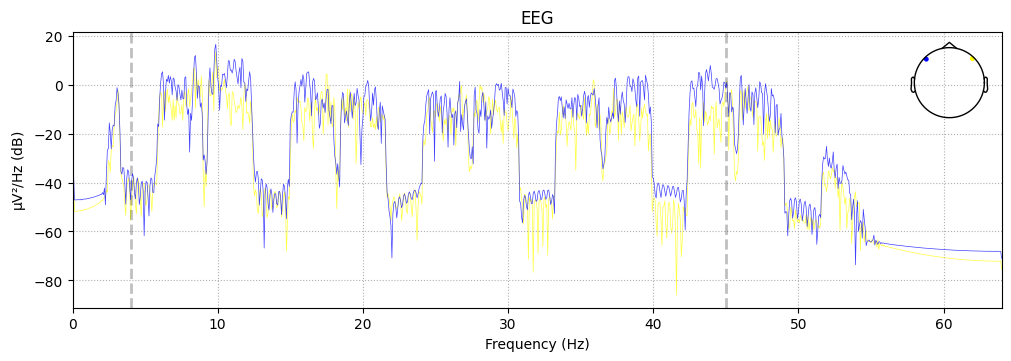

In [41]:
selected_channel=['F7','F8']

new_raw.pick_channels(selected_channel).plot_psd()

In [74]:
file_path_1 = './raw_data_edf/S01.edf'
raw_data = mne.io.read_raw_edf(file_path_1, preload=True,eog=None) 
info = raw_data.info
info_summary = {
        'Channels': raw_data.ch_names,
        'Sampling rate': raw_data.info['sfreq'],
        'Data shape': raw_data.get_data().shape
}

info,raw_data.ch_names,raw_data.get_data().shape

Extracting EDF parameters from d:\Anxiety\DASPS_Database\DASPS_Database\raw_data_edf\S01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 42111  =      0.000 ...   328.992 secs...


(<Info | 8 non-empty values
  bads: []
  ch_names: COUNTER, INTERPOLATED, AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, ...
  chs: 36 EEG
  custom_ref_applied: False
  highpass: 0.0 Hz
  lowpass: 64.0 Hz
  meas_date: 2017-01-13 15:07:03 UTC
  nchan: 36
  projs: []
  sfreq: 128.0 Hz
  subject_info: 1 item (dict)
 >,
 ['COUNTER',
  'INTERPOLATED',
  'AF3',
  'F7',
  'F3',
  'FC5',
  'T7',
  'P7',
  'O1',
  'O2',
  'P8',
  'T8',
  'FC6',
  'F4',
  'F8',
  'AF4',
  'RAW_CQ',
  'CQ_AF3',
  'CQ_F7',
  'CQ_F3',
  'CQ_FC5',
  'CQ_T7',
  'CQ_P7',
  'CQ_O1',
  'CQ_O2',
  'CQ_P8',
  'CQ_T8',
  'CQ_FC6',
  'CQ_F4',
  'CQ_F8',
  'CQ_AF4',
  'CQ_CMS',
  'CQ_DRL',
  'GYROX',
  'GYROY',
  'MARKER'],
 (36, 42112))

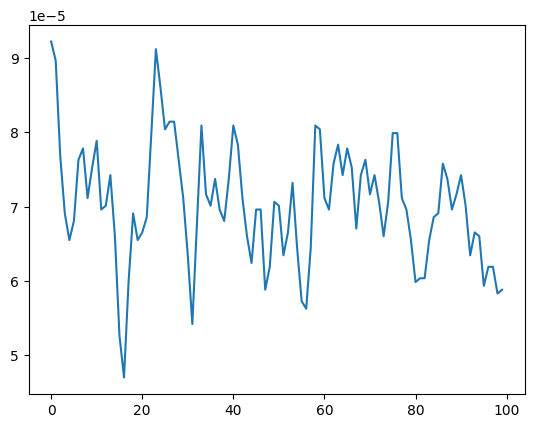

In [75]:
import matplotlib.pyplot as plt
signal=raw_data.get_data()[13,:100]
plt.plot(signal)
plt.show()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
<Info | 8 non-empty values
 bads: []
 ch_names: COUNTER, INTERPOLATED, AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, ...
 chs: 36 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: 2017-01-13 15:07:03 UTC
 nchan: 36
 projs: []
 sfreq: 128.0 Hz
 subject_info: 1 item (dict)
>


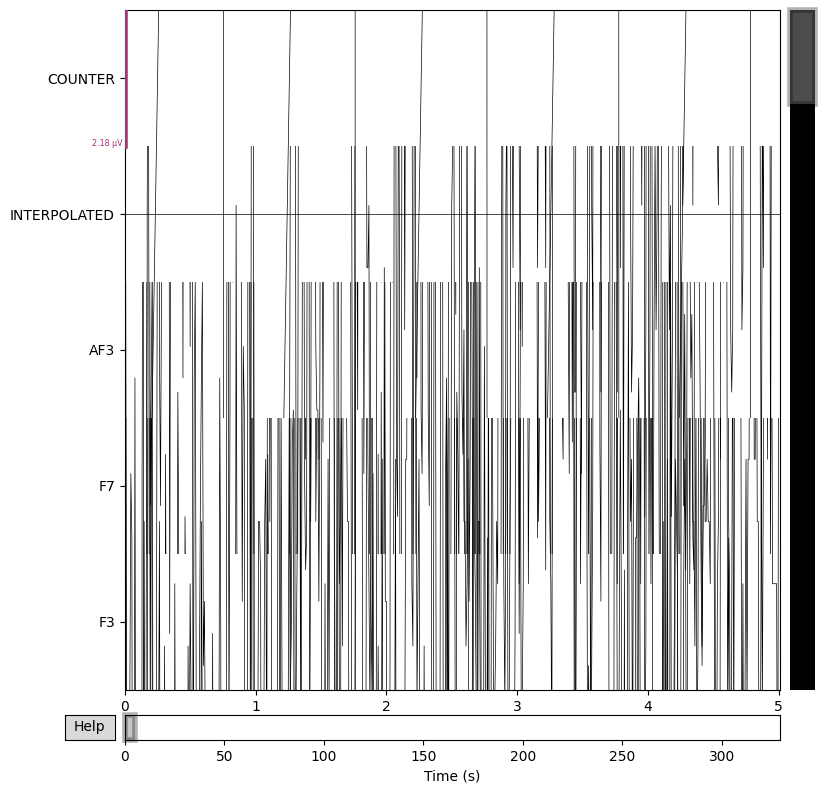

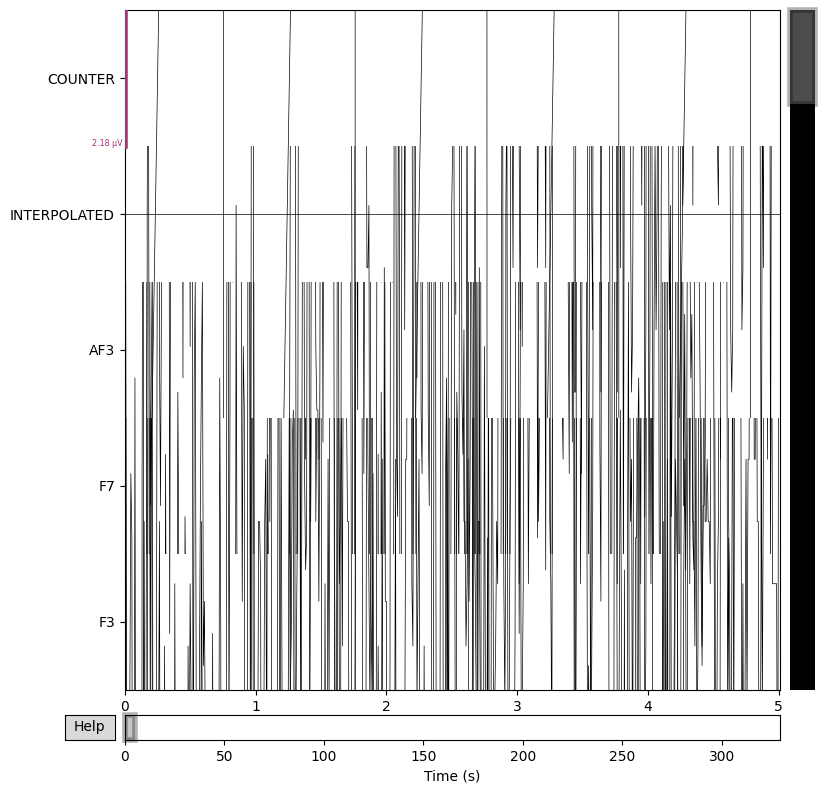

In [76]:
# Check the first few data points of the first channel
print(raw_data.get_data()[1,:10])

# Check the info attribute for units information
print(raw_data.info)

# Visualize the data using MNE's built-in plotting function
raw_data.plot(start=0, duration=5, n_channels=5, scalings='auto')
